# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

Using TensorFlow backend.


The following code block contains an 8x8 matrix that will be used as a maze object:

In [2]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [3]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [4]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


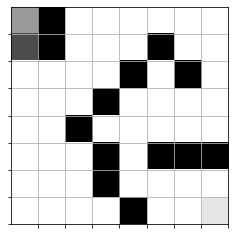

In [5]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [6]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [7]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [8]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [9]:
def qtrain(model, maze, **opt):
    # exploration factor
    global epsilon 

    # number of epochs (default: 15000)
    n_epoch = opt.get('n_epoch', 15000)
    
    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)
    
    # maximum data size for training
    data_size = opt.get('data_size', 50)
    
    # start time for training
    start_time = datetime.datetime.now()
    
    # Construct environment/game from numpy array: maze
    qmaze = TreasureMaze(maze)
    
    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose outcomes for each epoch
    hsize = qmaze.maze.size // 2   # history window size
    win_rate = 0.0

    for epoch in range(n_epoch):
        # Clear a few lines for visual separation
        print("\n" + "=" * 60)
        print(f"Epoch {epoch + 1}/{n_epoch}".center(60))
        print("=" * 60)
        print("Starting new game/episode...\n")

        # Randomly select a free cell to start the agent
        # (agent_cell is an array of length 2; convert to list for reset)
        agent_cell = np.random.randint(0, high=7, size=2)
        qmaze.reset(agent_cell.tolist())
        envstate = qmaze.observe()
        loss = 0
        n_episodes = 0
        
        # Run the game until it is over
        while qmaze.game_status() == 'not_over':
            previous_envstate = envstate
            valid_actions = qmaze.valid_actions()
            
            # Epsilon-greedy: random action with probability epsilon, else choose best predicted
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(envstate))
            
            # Take the action and update the environment state
            envstate, reward, game_status = qmaze.act(action)
            n_episodes += 1
            
            # Remember the episode: (prev state, action, reward, new state, game status)
            episode = [previous_envstate, action, reward, envstate, game_status]
            experience.remember(episode)
            
            # Get training data from replay memory and train the model
            inputs, targets = experience.get_data()
            history = model.fit(inputs, targets, epochs=8, batch_size=24, verbose=0)
            loss = model.evaluate(inputs, targets, verbose=0)
            
            # If the game ended (win or lose), record the outcome and break the loop.
            if game_status == 'win':
                win_history.append(1)
                win_rate = sum(win_history) / len(win_history)
                break
            elif game_status == 'lose':
                win_history.append(0)
                win_rate = sum(win_history) / len(win_history)
                break
        
        # Optional messages when win rate is high
        if win_rate > epsilon:
            print("Win rate is larger than epsilon!")
            if completion_check(model, qmaze):
                print("Completion check passed!")
        
        # Calculate elapsed time
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        
        # Build and print the formatted output for this epoch
        output_line = (
            f"Epoch: {epoch + 1:03d}/{n_epoch} | "
            f"Loss: {loss:.4f} | "
            f"Episodes: {n_episodes:02d} | "
            f"Win count: {sum(win_history):03d} | "
            f"Win rate: {win_rate:.3f} | "
            f"Time elapsed: {t}"
        )
        print(output_line)
        
        # Adjust epsilon when win rate is high
        if win_rate > 0.9:
            epsilon = 0.05
        
        # Early stopping if recent history is 100% wins and completion check passes
        if len(win_history) >= hsize and sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print(f"\n>>> Reached 100% win rate at epoch: {epoch + 1} <<<")
            break

    # Final training summary
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("\n" + "=" * 60)
    print(f"Training complete: Epochs run: {epoch + 1}, "
          f"Max Memory: {max_memory}, Batch Data Size: {data_size}, "
          f"Total Time: {t}")
    print("=" * 60 + "\n")
    return seconds

# Utility function for formatting elapsed time into a readable string:
def format_time(seconds):
    if seconds < 400:
        return f"{seconds:.1f} seconds"
    elif seconds < 4000:
        return f"{seconds / 60.0:.2f} minutes"
    else:
        return f"{seconds / 3600.0:.2f} hours"


## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

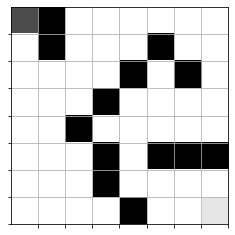

In [10]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [11]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)


                       Epoch 1/15000                        
Starting new game/episode...

Epoch: 001/15000 | Loss: 0.0000 | Episodes: 134 | Win count: 000 | Win rate: 0.000 | Time elapsed: 4.9 seconds

                       Epoch 2/15000                        
Starting new game/episode...

Epoch: 002/15000 | Loss: 0.0002 | Episodes: 135 | Win count: 000 | Win rate: 0.000 | Time elapsed: 8.6 seconds

                       Epoch 3/15000                        
Starting new game/episode...

Epoch: 003/15000 | Loss: 0.0001 | Episodes: 139 | Win count: 000 | Win rate: 0.000 | Time elapsed: 12.4 seconds

                       Epoch 4/15000                        
Starting new game/episode...

Epoch: 004/15000 | Loss: 0.0010 | Episodes: 146 | Win count: 000 | Win rate: 0.000 | Time elapsed: 16.5 seconds

                       Epoch 5/15000                        
Starting new game/episode...

Epoch: 005/15000 | Loss: 0.0003 | Episodes: 135 | Win count: 000 | Win rate: 0.000 | Time elap

Win rate is larger than epsilon!
Epoch: 025/15000 | Loss: 0.0014 | Episodes: 144 | Win count: 004 | Win rate: 0.160 | Time elapsed: 91.8 seconds

                       Epoch 26/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 026/15000 | Loss: 0.0028 | Episodes: 154 | Win count: 004 | Win rate: 0.154 | Time elapsed: 95.9 seconds

                       Epoch 27/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 027/15000 | Loss: 0.0016 | Episodes: 142 | Win count: 004 | Win rate: 0.148 | Time elapsed: 100.1 seconds

                       Epoch 28/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 028/15000 | Loss: 0.0008 | Episodes: 141 | Win count: 004 | Win rate: 0.143 | Time elapsed: 103.8 seconds

                       Epoch 29/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 029/15000 

Win rate is larger than epsilon!
Epoch: 048/15000 | Loss: 0.0006 | Episodes: 145 | Win count: 008 | Win rate: 0.167 | Time elapsed: 171.7 seconds

                       Epoch 49/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 049/15000 | Loss: 0.0009 | Episodes: 154 | Win count: 008 | Win rate: 0.163 | Time elapsed: 176.1 seconds

                       Epoch 50/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 050/15000 | Loss: 0.0024 | Episodes: 142 | Win count: 008 | Win rate: 0.160 | Time elapsed: 180.1 seconds

                       Epoch 51/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 051/15000 | Loss: 0.0013 | Episodes: 141 | Win count: 008 | Win rate: 0.157 | Time elapsed: 183.9 seconds

                       Epoch 52/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 052/1500

Win rate is larger than epsilon!
Epoch: 071/15000 | Loss: 0.0020 | Episodes: 155 | Win count: 013 | Win rate: 0.183 | Time elapsed: 252.8 seconds

                       Epoch 72/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 072/15000 | Loss: 0.0006 | Episodes: 144 | Win count: 013 | Win rate: 0.181 | Time elapsed: 256.9 seconds

                       Epoch 73/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 073/15000 | Loss: 0.0008 | Episodes: 159 | Win count: 013 | Win rate: 0.178 | Time elapsed: 261.2 seconds

                       Epoch 74/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 074/15000 | Loss: 0.0015 | Episodes: 149 | Win count: 013 | Win rate: 0.176 | Time elapsed: 265.6 seconds

                       Epoch 75/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 075/1500

Win rate is larger than epsilon!
Epoch: 094/15000 | Loss: 0.0012 | Episodes: 136 | Win count: 021 | Win rate: 0.223 | Time elapsed: 320.8 seconds

                       Epoch 95/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 095/15000 | Loss: 0.0006 | Episodes: 25 | Win count: 022 | Win rate: 0.232 | Time elapsed: 321.5 seconds

                       Epoch 96/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 096/15000 | Loss: 0.0009 | Episodes: 39 | Win count: 023 | Win rate: 0.240 | Time elapsed: 322.7 seconds

                       Epoch 97/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 097/15000 | Loss: 0.0016 | Episodes: 02 | Win count: 024 | Win rate: 0.247 | Time elapsed: 322.8 seconds

                       Epoch 98/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 098/15000 |

Win rate is larger than epsilon!
Epoch: 117/15000 | Loss: 0.0003 | Episodes: 151 | Win count: 030 | Win rate: 0.256 | Time elapsed: 386.9 seconds

                      Epoch 118/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 118/15000 | Loss: 0.0009 | Episodes: 148 | Win count: 030 | Win rate: 0.254 | Time elapsed: 391.0 seconds

                      Epoch 119/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 119/15000 | Loss: 0.0012 | Episodes: 148 | Win count: 030 | Win rate: 0.252 | Time elapsed: 395.1 seconds

                      Epoch 120/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 120/15000 | Loss: 0.0011 | Episodes: 139 | Win count: 030 | Win rate: 0.250 | Time elapsed: 399.2 seconds

                      Epoch 121/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 121/1500

Win rate is larger than epsilon!
Epoch: 140/15000 | Loss: 0.0003 | Episodes: 150 | Win count: 037 | Win rate: 0.264 | Time elapsed: 7.64 minutes

                      Epoch 141/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 141/15000 | Loss: 0.0015 | Episodes: 149 | Win count: 037 | Win rate: 0.262 | Time elapsed: 7.71 minutes

                      Epoch 142/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 142/15000 | Loss: 0.0010 | Episodes: 146 | Win count: 037 | Win rate: 0.261 | Time elapsed: 7.77 minutes

                      Epoch 143/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 143/15000 | Loss: 0.0000 | Episodes: 143 | Win count: 037 | Win rate: 0.259 | Time elapsed: 7.84 minutes

                      Epoch 144/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 144/15000 | 

Win rate is larger than epsilon!
Epoch: 163/15000 | Loss: 0.0001 | Episodes: 142 | Win count: 044 | Win rate: 0.270 | Time elapsed: 8.86 minutes

                      Epoch 164/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 164/15000 | Loss: 0.0013 | Episodes: 04 | Win count: 045 | Win rate: 0.274 | Time elapsed: 8.86 minutes

                      Epoch 165/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 165/15000 | Loss: 0.0011 | Episodes: 135 | Win count: 045 | Win rate: 0.273 | Time elapsed: 8.93 minutes

                      Epoch 166/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 166/15000 | Loss: 0.0015 | Episodes: 58 | Win count: 046 | Win rate: 0.277 | Time elapsed: 8.96 minutes

                      Epoch 167/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 167/15000 | Lo

Win rate is larger than epsilon!
Epoch: 186/15000 | Loss: 0.0005 | Episodes: 145 | Win count: 055 | Win rate: 0.296 | Time elapsed: 9.94 minutes

                      Epoch 187/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 187/15000 | Loss: 0.0004 | Episodes: 03 | Win count: 056 | Win rate: 0.299 | Time elapsed: 9.94 minutes

                      Epoch 188/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 188/15000 | Loss: 0.0001 | Episodes: 135 | Win count: 056 | Win rate: 0.298 | Time elapsed: 10.01 minutes

                      Epoch 189/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 189/15000 | Loss: 0.0006 | Episodes: 16 | Win count: 057 | Win rate: 0.302 | Time elapsed: 10.02 minutes

                      Epoch 190/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 190/15000 | 

Win rate is larger than epsilon!
Epoch: 209/15000 | Loss: 0.0016 | Episodes: 154 | Win count: 066 | Win rate: 0.316 | Time elapsed: 10.89 minutes

                      Epoch 210/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 210/15000 | Loss: 0.0005 | Episodes: 144 | Win count: 066 | Win rate: 0.314 | Time elapsed: 10.96 minutes

                      Epoch 211/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 211/15000 | Loss: 0.0014 | Episodes: 19 | Win count: 067 | Win rate: 0.318 | Time elapsed: 10.97 minutes

                      Epoch 212/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 212/15000 | Loss: 0.0018 | Episodes: 143 | Win count: 067 | Win rate: 0.316 | Time elapsed: 11.04 minutes

                      Epoch 213/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 213/15000

Win rate is larger than epsilon!
Epoch: 232/15000 | Loss: 0.0003 | Episodes: 60 | Win count: 077 | Win rate: 0.332 | Time elapsed: 11.86 minutes

                      Epoch 233/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 233/15000 | Loss: 0.0011 | Episodes: 145 | Win count: 077 | Win rate: 0.330 | Time elapsed: 11.93 minutes

                      Epoch 234/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 234/15000 | Loss: 0.0016 | Episodes: 155 | Win count: 077 | Win rate: 0.329 | Time elapsed: 12.00 minutes

                      Epoch 235/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 235/15000 | Loss: 0.0004 | Episodes: 143 | Win count: 077 | Win rate: 0.328 | Time elapsed: 12.07 minutes

                      Epoch 236/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 236/15000

Win rate is larger than epsilon!
Epoch: 255/15000 | Loss: 0.0002 | Episodes: 148 | Win count: 088 | Win rate: 0.345 | Time elapsed: 12.96 minutes

                      Epoch 256/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 256/15000 | Loss: 0.0011 | Episodes: 02 | Win count: 089 | Win rate: 0.348 | Time elapsed: 12.97 minutes

                      Epoch 257/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 257/15000 | Loss: 0.0017 | Episodes: 150 | Win count: 089 | Win rate: 0.346 | Time elapsed: 13.04 minutes

                      Epoch 258/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 258/15000 | Loss: 0.0011 | Episodes: 149 | Win count: 089 | Win rate: 0.345 | Time elapsed: 13.11 minutes

                      Epoch 259/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 259/15000

Win rate is larger than epsilon!
Epoch: 278/15000 | Loss: 0.0017 | Episodes: 140 | Win count: 098 | Win rate: 0.353 | Time elapsed: 14.00 minutes

                      Epoch 279/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 279/15000 | Loss: 0.0001 | Episodes: 143 | Win count: 098 | Win rate: 0.351 | Time elapsed: 14.07 minutes

                      Epoch 280/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 280/15000 | Loss: 0.0005 | Episodes: 146 | Win count: 098 | Win rate: 0.350 | Time elapsed: 14.14 minutes

                      Epoch 281/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 281/15000 | Loss: 0.0003 | Episodes: 145 | Win count: 098 | Win rate: 0.349 | Time elapsed: 14.21 minutes

                      Epoch 282/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 282/1500

Win rate is larger than epsilon!
Epoch: 301/15000 | Loss: 0.0003 | Episodes: 140 | Win count: 105 | Win rate: 0.349 | Time elapsed: 15.24 minutes

                      Epoch 302/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 302/15000 | Loss: 0.0017 | Episodes: 148 | Win count: 106 | Win rate: 0.351 | Time elapsed: 15.31 minutes

                      Epoch 303/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 303/15000 | Loss: 0.0015 | Episodes: 13 | Win count: 107 | Win rate: 0.353 | Time elapsed: 15.32 minutes

                      Epoch 304/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 304/15000 | Loss: 0.0018 | Episodes: 15 | Win count: 108 | Win rate: 0.355 | Time elapsed: 15.33 minutes

                      Epoch 305/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 305/15000 

Win rate is larger than epsilon!
Epoch: 324/15000 | Loss: 0.0019 | Episodes: 62 | Win count: 124 | Win rate: 0.383 | Time elapsed: 15.86 minutes

                      Epoch 325/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 325/15000 | Loss: 0.0014 | Episodes: 54 | Win count: 125 | Win rate: 0.385 | Time elapsed: 15.89 minutes

                      Epoch 326/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 326/15000 | Loss: 0.0014 | Episodes: 144 | Win count: 125 | Win rate: 0.383 | Time elapsed: 15.96 minutes

                      Epoch 327/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 327/15000 | Loss: 0.0009 | Episodes: 02 | Win count: 126 | Win rate: 0.385 | Time elapsed: 15.96 minutes

                      Epoch 328/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 328/15000 |

Win rate is larger than epsilon!
Epoch: 347/15000 | Loss: 0.0014 | Episodes: 86 | Win count: 143 | Win rate: 0.412 | Time elapsed: 16.62 minutes

                      Epoch 348/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 348/15000 | Loss: 0.0012 | Episodes: 39 | Win count: 144 | Win rate: 0.414 | Time elapsed: 16.64 minutes

                      Epoch 349/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 349/15000 | Loss: 0.0014 | Episodes: 146 | Win count: 144 | Win rate: 0.413 | Time elapsed: 16.71 minutes

                      Epoch 350/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 350/15000 | Loss: 0.0010 | Episodes: 45 | Win count: 145 | Win rate: 0.414 | Time elapsed: 16.73 minutes

                      Epoch 351/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 351/15000 |

Win rate is larger than epsilon!
Epoch: 370/15000 | Loss: 0.0002 | Episodes: 150 | Win count: 159 | Win rate: 0.430 | Time elapsed: 17.42 minutes

                      Epoch 371/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 371/15000 | Loss: 0.0013 | Episodes: 03 | Win count: 160 | Win rate: 0.431 | Time elapsed: 17.42 minutes

                      Epoch 372/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 372/15000 | Loss: 0.0003 | Episodes: 55 | Win count: 161 | Win rate: 0.433 | Time elapsed: 17.45 minutes

                      Epoch 373/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 373/15000 | Loss: 0.0013 | Episodes: 39 | Win count: 162 | Win rate: 0.434 | Time elapsed: 17.47 minutes

                      Epoch 374/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 374/15000 |

Epoch: 393/15000 | Loss: 0.0012 | Episodes: 02 | Win count: 176 | Win rate: 0.448 | Time elapsed: 18.18 minutes

                      Epoch 394/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 394/15000 | Loss: 0.0015 | Episodes: 27 | Win count: 177 | Win rate: 0.449 | Time elapsed: 18.20 minutes

                      Epoch 395/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 395/15000 | Loss: 0.0003 | Episodes: 18 | Win count: 178 | Win rate: 0.451 | Time elapsed: 18.20 minutes

                      Epoch 396/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 396/15000 | Loss: 0.0009 | Episodes: 146 | Win count: 178 | Win rate: 0.449 | Time elapsed: 18.27 minutes

                      Epoch 397/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 397/15000 | Loss: 0.0018 | Episodes: 15 | Wi

Win rate is larger than epsilon!
Epoch: 416/15000 | Loss: 0.0007 | Episodes: 25 | Win count: 196 | Win rate: 0.471 | Time elapsed: 18.70 minutes

                      Epoch 417/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 417/15000 | Loss: 0.0004 | Episodes: 146 | Win count: 197 | Win rate: 0.472 | Time elapsed: 18.77 minutes

                      Epoch 418/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 418/15000 | Loss: 0.0012 | Episodes: 20 | Win count: 198 | Win rate: 0.474 | Time elapsed: 18.78 minutes

                      Epoch 419/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 419/15000 | Loss: 0.0006 | Episodes: 24 | Win count: 199 | Win rate: 0.475 | Time elapsed: 18.79 minutes

                      Epoch 420/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 420/15000 |

Win rate is larger than epsilon!
Epoch: 439/15000 | Loss: 0.0022 | Episodes: 13 | Win count: 218 | Win rate: 0.497 | Time elapsed: 19.18 minutes

                      Epoch 440/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 440/15000 | Loss: 0.0022 | Episodes: 30 | Win count: 219 | Win rate: 0.498 | Time elapsed: 19.20 minutes

                      Epoch 441/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 441/15000 | Loss: 0.0014 | Episodes: 05 | Win count: 220 | Win rate: 0.499 | Time elapsed: 19.20 minutes

                      Epoch 442/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 442/15000 | Loss: 0.0021 | Episodes: 31 | Win count: 221 | Win rate: 0.500 | Time elapsed: 19.22 minutes

                      Epoch 443/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 443/15000 | 

Epoch: 462/15000 | Loss: 0.0012 | Episodes: 02 | Win count: 240 | Win rate: 0.519 | Time elapsed: 19.66 minutes

                      Epoch 463/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 463/15000 | Loss: 0.0014 | Episodes: 06 | Win count: 241 | Win rate: 0.521 | Time elapsed: 19.67 minutes

                      Epoch 464/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 464/15000 | Loss: 0.0007 | Episodes: 21 | Win count: 242 | Win rate: 0.522 | Time elapsed: 19.68 minutes

                      Epoch 465/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 465/15000 | Loss: 0.0009 | Episodes: 21 | Win count: 243 | Win rate: 0.523 | Time elapsed: 19.69 minutes

                      Epoch 466/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 466/15000 | Loss: 0.0005 | Episodes: 25 | Win

Win rate is larger than epsilon!
Epoch: 485/15000 | Loss: 0.0013 | Episodes: 20 | Win count: 263 | Win rate: 0.542 | Time elapsed: 20.00 minutes

                      Epoch 486/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 486/15000 | Loss: 0.0017 | Episodes: 20 | Win count: 264 | Win rate: 0.543 | Time elapsed: 20.01 minutes

                      Epoch 487/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 487/15000 | Loss: 0.0005 | Episodes: 87 | Win count: 265 | Win rate: 0.544 | Time elapsed: 20.06 minutes

                      Epoch 488/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 488/15000 | Loss: 0.0013 | Episodes: 45 | Win count: 266 | Win rate: 0.545 | Time elapsed: 20.08 minutes

                      Epoch 489/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 489/15000 | 

Win rate is larger than epsilon!
Epoch: 508/15000 | Loss: 0.0014 | Episodes: 26 | Win count: 285 | Win rate: 0.561 | Time elapsed: 20.53 minutes

                      Epoch 509/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 509/15000 | Loss: 0.0017 | Episodes: 19 | Win count: 286 | Win rate: 0.562 | Time elapsed: 20.54 minutes

                      Epoch 510/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 510/15000 | Loss: 0.0008 | Episodes: 94 | Win count: 287 | Win rate: 0.563 | Time elapsed: 20.59 minutes

                      Epoch 511/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 511/15000 | Loss: 0.0015 | Episodes: 69 | Win count: 288 | Win rate: 0.564 | Time elapsed: 20.63 minutes

                      Epoch 512/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 512/15000 | 

Win rate is larger than epsilon!
Epoch: 531/15000 | Loss: 0.0013 | Episodes: 47 | Win count: 306 | Win rate: 0.576 | Time elapsed: 21.16 minutes

                      Epoch 532/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 532/15000 | Loss: 0.0014 | Episodes: 29 | Win count: 307 | Win rate: 0.577 | Time elapsed: 21.18 minutes

                      Epoch 533/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 533/15000 | Loss: 0.0004 | Episodes: 76 | Win count: 308 | Win rate: 0.578 | Time elapsed: 21.21 minutes

                      Epoch 534/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 534/15000 | Loss: 0.0011 | Episodes: 22 | Win count: 309 | Win rate: 0.579 | Time elapsed: 21.23 minutes

                      Epoch 535/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 535/15000 | 

Win rate is larger than epsilon!
Epoch: 554/15000 | Loss: 0.0004 | Episodes: 16 | Win count: 329 | Win rate: 0.594 | Time elapsed: 21.46 minutes

                      Epoch 555/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 555/15000 | Loss: 0.0008 | Episodes: 21 | Win count: 330 | Win rate: 0.595 | Time elapsed: 21.47 minutes

                      Epoch 556/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 556/15000 | Loss: 0.0013 | Episodes: 27 | Win count: 331 | Win rate: 0.595 | Time elapsed: 21.50 minutes

                      Epoch 557/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 557/15000 | Loss: 0.0010 | Episodes: 81 | Win count: 332 | Win rate: 0.596 | Time elapsed: 21.54 minutes

                      Epoch 558/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 558/15000 | 

Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 577/15000 | Loss: 0.0005 | Episodes: 15 | Win count: 352 | Win rate: 0.610 | Time elapsed: 21.85 minutes

                      Epoch 578/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 578/15000 | Loss: 0.0007 | Episodes: 07 | Win count: 353 | Win rate: 0.611 | Time elapsed: 21.85 minutes

                      Epoch 579/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 579/15000 | Loss: 0.0007 | Episodes: 05 | Win count: 354 | Win rate: 0.611 | Time elapsed: 21.86 minutes

                      Epoch 580/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 580/15000 | Loss: 0.0008 | Episodes: 16 | Win count: 355 | Win rate: 0.612 | Time elapsed: 21.88 minutes

                      Epoch 581/15000                       
Starting new game/episode...

Win rate is larger tha

Win rate is larger than epsilon!
Epoch: 600/15000 | Loss: 0.0003 | Episodes: 28 | Win count: 375 | Win rate: 0.625 | Time elapsed: 22.15 minutes

                      Epoch 601/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 601/15000 | Loss: 0.0004 | Episodes: 91 | Win count: 376 | Win rate: 0.626 | Time elapsed: 22.20 minutes

                      Epoch 602/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 602/15000 | Loss: 0.0017 | Episodes: 10 | Win count: 377 | Win rate: 0.626 | Time elapsed: 22.21 minutes

                      Epoch 603/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 603/15000 | Loss: 0.0008 | Episodes: 59 | Win count: 378 | Win rate: 0.627 | Time elapsed: 22.24 minutes

                      Epoch 604/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 604/15000 | 

Win rate is larger than epsilon!
Epoch: 623/15000 | Loss: 0.0013 | Episodes: 23 | Win count: 396 | Win rate: 0.636 | Time elapsed: 22.67 minutes

                      Epoch 624/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 624/15000 | Loss: 0.0014 | Episodes: 31 | Win count: 397 | Win rate: 0.636 | Time elapsed: 22.69 minutes

                      Epoch 625/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 625/15000 | Loss: 0.0002 | Episodes: 33 | Win count: 398 | Win rate: 0.637 | Time elapsed: 22.71 minutes

                      Epoch 626/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 626/15000 | Loss: 0.0013 | Episodes: 25 | Win count: 399 | Win rate: 0.637 | Time elapsed: 22.72 minutes

                      Epoch 627/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 627/15000 | 

Win rate is larger than epsilon!
Epoch: 646/15000 | Loss: 0.0009 | Episodes: 23 | Win count: 419 | Win rate: 0.649 | Time elapsed: 23.10 minutes

                      Epoch 647/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 647/15000 | Loss: 0.0007 | Episodes: 18 | Win count: 420 | Win rate: 0.649 | Time elapsed: 23.12 minutes

                      Epoch 648/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 648/15000 | Loss: 0.0007 | Episodes: 21 | Win count: 421 | Win rate: 0.650 | Time elapsed: 23.14 minutes

                      Epoch 649/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 649/15000 | Loss: 0.0019 | Episodes: 79 | Win count: 422 | Win rate: 0.650 | Time elapsed: 23.18 minutes

                      Epoch 650/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 650/15000 | 

Epoch: 669/15000 | Loss: 0.0012 | Episodes: 06 | Win count: 442 | Win rate: 0.661 | Time elapsed: 23.61 minutes

                      Epoch 670/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 670/15000 | Loss: 0.0010 | Episodes: 09 | Win count: 443 | Win rate: 0.661 | Time elapsed: 23.62 minutes

                      Epoch 671/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 671/15000 | Loss: 0.0016 | Episodes: 32 | Win count: 444 | Win rate: 0.662 | Time elapsed: 23.63 minutes

                      Epoch 672/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 672/15000 | Loss: 0.0007 | Episodes: 07 | Win count: 445 | Win rate: 0.662 | Time elapsed: 23.64 minutes

                      Epoch 673/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 673/15000 | Loss: 0.0010 | Episodes: 40 | Win

Win rate is larger than epsilon!
Epoch: 692/15000 | Loss: 0.0005 | Episodes: 13 | Win count: 463 | Win rate: 0.669 | Time elapsed: 24.11 minutes

                      Epoch 693/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 693/15000 | Loss: 0.0004 | Episodes: 91 | Win count: 464 | Win rate: 0.670 | Time elapsed: 24.15 minutes

                      Epoch 694/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 694/15000 | Loss: 0.0010 | Episodes: 63 | Win count: 465 | Win rate: 0.670 | Time elapsed: 24.18 minutes

                      Epoch 695/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 695/15000 | Loss: 0.0015 | Episodes: 11 | Win count: 466 | Win rate: 0.671 | Time elapsed: 24.19 minutes

                      Epoch 696/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 696/15000 | 

Win rate is larger than epsilon!
Epoch: 715/15000 | Loss: 0.0011 | Episodes: 84 | Win count: 486 | Win rate: 0.680 | Time elapsed: 24.59 minutes

                      Epoch 716/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 716/15000 | Loss: 0.0013 | Episodes: 28 | Win count: 487 | Win rate: 0.680 | Time elapsed: 24.60 minutes

                      Epoch 717/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 717/15000 | Loss: 0.0017 | Episodes: 58 | Win count: 488 | Win rate: 0.681 | Time elapsed: 24.63 minutes

                      Epoch 718/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 718/15000 | Loss: 0.0006 | Episodes: 66 | Win count: 489 | Win rate: 0.681 | Time elapsed: 24.67 minutes

                      Epoch 719/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 719/15000 | 

Win rate is larger than epsilon!
Epoch: 738/15000 | Loss: 0.0006 | Episodes: 04 | Win count: 507 | Win rate: 0.687 | Time elapsed: 25.12 minutes

                      Epoch 739/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 739/15000 | Loss: 0.0007 | Episodes: 128 | Win count: 508 | Win rate: 0.687 | Time elapsed: 25.19 minutes

                      Epoch 740/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 740/15000 | Loss: 0.0012 | Episodes: 60 | Win count: 509 | Win rate: 0.688 | Time elapsed: 25.22 minutes

                      Epoch 741/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 741/15000 | Loss: 0.0010 | Episodes: 11 | Win count: 510 | Win rate: 0.688 | Time elapsed: 25.22 minutes

                      Epoch 742/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 742/15000 |

Win rate is larger than epsilon!
Epoch: 761/15000 | Loss: 0.0002 | Episodes: 15 | Win count: 530 | Win rate: 0.696 | Time elapsed: 25.45 minutes

                      Epoch 762/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 762/15000 | Loss: 0.0001 | Episodes: 61 | Win count: 531 | Win rate: 0.697 | Time elapsed: 25.48 minutes

                      Epoch 763/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 763/15000 | Loss: 0.0003 | Episodes: 05 | Win count: 532 | Win rate: 0.697 | Time elapsed: 25.48 minutes

                      Epoch 764/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 764/15000 | Loss: 0.0005 | Episodes: 33 | Win count: 533 | Win rate: 0.698 | Time elapsed: 25.50 minutes

                      Epoch 765/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 765/15000 | 


Win rate is larger than epsilon!
Epoch: 784/15000 | Loss: 0.0011 | Episodes: 25 | Win count: 553 | Win rate: 0.705 | Time elapsed: 25.81 minutes

                      Epoch 785/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 785/15000 | Loss: 0.0010 | Episodes: 37 | Win count: 554 | Win rate: 0.706 | Time elapsed: 25.83 minutes

                      Epoch 786/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 786/15000 | Loss: 0.0010 | Episodes: 21 | Win count: 555 | Win rate: 0.706 | Time elapsed: 25.85 minutes

                      Epoch 787/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 787/15000 | Loss: 0.0007 | Episodes: 15 | Win count: 556 | Win rate: 0.706 | Time elapsed: 25.87 minutes

                      Epoch 788/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 788/15000 |

Epoch: 807/15000 | Loss: 0.0007 | Episodes: 02 | Win count: 576 | Win rate: 0.714 | Time elapsed: 26.27 minutes

                      Epoch 808/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 808/15000 | Loss: 0.0008 | Episodes: 28 | Win count: 577 | Win rate: 0.714 | Time elapsed: 26.29 minutes

                      Epoch 809/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 809/15000 | Loss: 0.0005 | Episodes: 40 | Win count: 578 | Win rate: 0.714 | Time elapsed: 26.32 minutes

                      Epoch 810/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 810/15000 | Loss: 0.0012 | Episodes: 39 | Win count: 579 | Win rate: 0.715 | Time elapsed: 26.35 minutes

                      Epoch 811/15000                       
Starting new game/episode...

Win rate is larger than epsilon!
Epoch: 811/15000 | Loss: 0.0009 | Episodes: 44 | Win

1585.54785

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

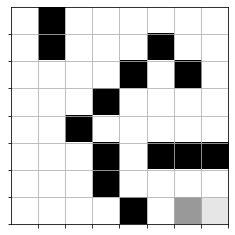

In [12]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

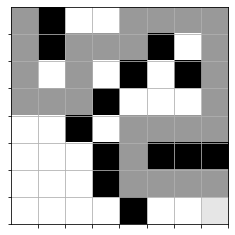

In [13]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.